# **Importing Libraries**

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import os
import pathlib
import pandas as pd
from sklearn import model_selection

# **Data Preprocessing**

In [5]:

# This code will copy the images from your google drive into the colab file storage.
! mkdir /tmp/Multi_Label_dataset
! rsync -ah --info=progress2 "/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images" /tmp/Multi_Label_dataset/


        191.14M 100%  955.74kB/s    0:03:15 (xfr#7876, to-chk=0/7877)


In [6]:
# Load the csv with the sample IDs and genres
csv_loc = "/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/train.csv"
dataset = pd.read_csv("/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/train.csv")

# Split the dataset into training and testing
data_train, data_test = model_selection.train_test_split(dataset, test_size=0.2)

# Convert the labels to arrays
labels_train = np.array(data_train.drop(['Id', 'Genre'],axis=1)).astype('float32')
labels_test = np.array(data_test.drop(['Id', 'Genre'],axis=1)).astype('float32')

# List of the genre names
genres = np.array(data_train.drop(['Id', 'Genre'],axis=1).columns)

# Build the file locations for the images
img_loc = "/tmp/Multi_Label_dataset/Images"

img_locs_train = np.array([[img_loc + '/' + id + '.jpg' for id in data_train['Id']]])
img_locs_test = [[img_loc + '/' + id + '.jpg' for id in data_test['Id']]]


# This function is provided to read in the image files from the folder
def parse_image(filename, label):
  image = tf.io.read_file(filename)
  image = tf.io.decode_jpeg(image)
  return image, label

# Create the initial datasets
train_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_train[0], labels_train))
test_list_ds = tf.data.Dataset.from_tensor_slices((img_locs_test[0], labels_test))

In [7]:
import tensorflow as tf

def img_process(image, label):
    # Convert the image to float32 data type
    image = tf.image.convert_image_dtype(image, tf.float32)

    # Resize the image to (64, 64)
    image = tf.image.resize(image, [64, 64])

    return image, label


In [8]:
import tensorflow as tf

def load_dataset(file_paths, labels, is_training=True):
    # Convert lists of file paths and labels into TensorFlow datasets
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Map the dataset to parse images
    dataset = dataset.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Map the dataset through the image processing function
    dataset = dataset.map(img_process, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_training:
        # Shuffle the dataset (only if it's the training set)
        dataset = dataset.shuffle(buffer_size=1000)

    # Batch the dataset
    dataset = dataset.batch(64)

    # Cache the dataset
    dataset = dataset.cache()

    # Prefetch the dataset to improve latency and throughput
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

# Assuming you have lists or numpy arrays for train_file_paths and train_labels
train_file_paths = ["/tmp/Multi_Label_dataset/Images/" + id + ".jpg" for id in data_train['Id']]
train_labels = labels_train

val_file_paths = ["/tmp/Multi_Label_dataset/Images/" + id + ".jpg" for id in data_test['Id']]
val_labels = labels_test

# Create the datasets
train_dataset = load_dataset(train_file_paths, train_labels, is_training=True)
val_dataset = load_dataset(val_file_paths, val_labels, is_training=False)


# **Model Architecture**

In [9]:
from tensorflow.keras.layers import Input, Conv2D, Dropout, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def build_model():
    # Input layer
    inputs = Input(shape=(64, 64, 3), name='Input')

    # First Convolutional block
    x = Conv2D(16, kernel_size=(3, 3), strides=(2, 2), padding='same', activation='relu', name='Conv0')(inputs)
    x = Dropout(0.2, name='Drop1')(x)

    # Second Convolutional block
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='Conv1')(x)
    x = Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', name='Conv2')(x)
    x = Dropout(0.2, name='Drop2')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Pool1')(x)

    # Third Convolutional block
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='Conv3')(x)
    x = Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', name='Conv4')(x)
    x = Dropout(0.2, name='Drop3')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Pool2')(x)

    # Fourth Convolutional block
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='Conv5')(x)
    x = Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu', name='Conv6')(x)
    x = Dropout(0.2, name='Drop4')(x)
    x = MaxPooling2D(pool_size=(2, 2), name='Pool3')(x)

    # Flattening the output of the last pooling layer
    x = Flatten(name='Flat')(x)

    # Fully connected layers
    x = Dense(1024, activation='relu', name='FC1')(x)
    x = Dropout(0.5, name='Drop5')(x)
    x = Dense(1024, activation='relu', name='FC2')(x)
    x = Dropout(0.5, name='Drop6')(x)

    # Output layer
    outputs = Dense(25, activation='sigmoid', name='Output')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs, name='model')

    return model

# Build the model
model = build_model()

# Display the model summary to check if it matches the provided summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 64, 64, 3)]       0         
                                                                 
 Conv0 (Conv2D)              (None, 32, 32, 16)        448       
                                                                 
 Drop1 (Dropout)             (None, 32, 32, 16)        0         
                                                                 
 Conv1 (Conv2D)              (None, 32, 32, 32)        4640      
                                                                 
 Conv2 (Conv2D)              (None, 32, 32, 32)        9248      
                                                                 
 Drop2 (Dropout)             (None, 32, 32, 32)        0         
                                                                 
 Pool1 (MaxPooling2D)        (None, 16, 16, 32)        0     

In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy

# Assume 'model' is the model you previously defined
def compile_model(model):
    # Configure the optimizer with a specific learning rate
    optimizer = Adam(learning_rate=1e-4)

    # Compile the model with the configured optimizer, loss function, and desired metrics
    model.compile(
        optimizer=optimizer,
        loss=BinaryCrossentropy(),
        metrics=[
            Precision(name='precision'),
            Recall(name='recall'),
            'accuracy'  # Add accuracy to the list of metrics
        ]
    )

# Compile the model
compile_model(model)


# **Model Training**

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the filepath where the checkpoint will be saved
checkpoint_filepath = '/content/checkpoint'

# Create the ModelCheckpoint callback
# Set 'save_best_only' to True to save only the best model according to the validation accuracy
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',   # Monitor validation accuracy
    verbose=1,
    save_best_only=True,      # Save the best model only
    mode='max',               # Maximize the monitored metric (validation accuracy)
    save_weights_only=True,   # Save only the weights
    save_freq='epoch'         # Check at the end of every epoch
)

# Now, this callback can be passed to the 'fit' method of the model during training.


In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

# Create the LearningRateScheduler callback
lr_callback = LearningRateScheduler(schedule=scheduler, verbose=1)

# This callback can now be included in the list of callbacks during the model training.


In [13]:
# Train the model
history = model.fit(
    train_dataset,                  # Training data
    validation_data=val_dataset,    # Validation data
    epochs=200,                      # Number of epochs
    callbacks=[checkpoint_callback, lr_callback],  # List of callbacks to use during training
    verbose=2                       # Verbose mode: 0 = silent, 1 = progress bar, 2 = one line per epoch
)

# `history` object holds a record of the loss values and metric values during training



Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/200

Epoch 1: val_accuracy improved from -inf to 0.30462, saving model to /content/checkpoint
91/91 - 40s - loss: 0.3189 - precision: 0.3301 - recall: 0.1860 - accuracy: 0.2097 - val_loss: 0.3395 - val_precision: 0.6857 - val_recall: 0.0071 - val_accuracy: 0.3046 - lr: 1.0000e-04 - 40s/epoch - 443ms/step

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/200

Epoch 2: val_accuracy did not improve from 0.30462
91/91 - 36s - loss: 0.2585 - precision: 0.4704 - recall: 0.1622 - accuracy: 0.2351 - val_loss: 0.3381 - val_precision: 0.5716 - val_recall: 0.1801 - val_accuracy: 0.2798 - lr: 1.0000e-04 - 36s/epoch - 393ms/step

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/200

Epoch 3: val_accuracy improved from 0.30462 to 0.33012, saving model to /content/checkpoint
91/91 - 36s - loss: 0.2497 - precision: 0.5076 - recall: 0.1785 -

In [14]:
#saving model into pickel file
import pickle

# Assuming `model` is your Keras/TensorFlow model
def save_model_pickle(model, filename):
    with open(filename, 'wb') as file:
        pickle.dump(model, file)

# Usage
save_model_pickle(history, 'movie_poster_classification.pkl')


In [15]:
from google.colab import files
files.download('movie_poster_classification.pkl')  # Replace 'your_file_name.pkl' with the actual file name


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Trained Model History and visalization**

In [16]:
# Access the history of training
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_precision = history.history['precision']  # Precision for the training set
val_precision = history.history['val_precision']  # Precision for the validation set
train_accuracy = history.history['accuracy']  # Accuracy for the training set
val_accuracy = history.history['val_accuracy']  # Accuracy for the validation set

# Example: Print the validation loss, precision, and accuracy
print("Validation Loss:", val_loss)
print("Validation Precision:", val_precision)
print("Validation Accuracy:", val_accuracy)  # Added print statement for validation accuracy


Validation Loss: [0.33946463465690613, 0.3380948007106781, 0.3173341751098633, 0.3092864155769348, 0.30508193373680115, 0.29854056239128113, 0.2921927869319916, 0.28691399097442627, 0.2843913435935974, 0.2745223939418793, 0.2746894657611847, 0.2725517451763153, 0.26846006512641907, 0.26527148485183716, 0.26628559827804565, 0.2652375102043152, 0.2640766203403473, 0.25986194610595703, 0.2586386501789093, 0.2586192786693573, 0.2558133006095886, 0.25578293204307556, 0.2537747919559479, 0.2541399896144867, 0.25312212109565735, 0.25230541825294495, 0.252591609954834, 0.2511266767978668, 0.25254902243614197, 0.24978892505168915, 0.2503122091293335, 0.2510174810886383, 0.24965782463550568, 0.24936021864414215, 0.248732328414917, 0.24948008358478546, 0.2473159283399582, 0.24887488782405853, 0.24835047125816345, 0.24843010306358337, 0.2498110681772232, 0.24713441729545593, 0.24916642904281616, 0.249228373169899, 0.24659767746925354, 0.24671348929405212, 0.24820026755332947, 0.24629177153110504, 

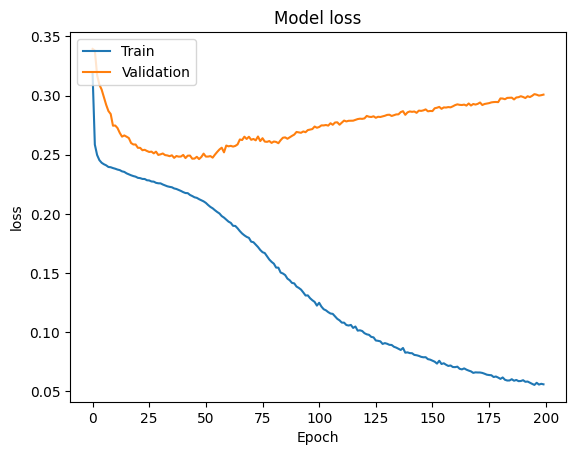

In [17]:
import matplotlib.pyplot as plt
def plot_metric(history, metric, val_metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title(f'Model {metric}')
    plt.ylabel(metric)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()
plot_metric(history, 'loss', 'val_loss')


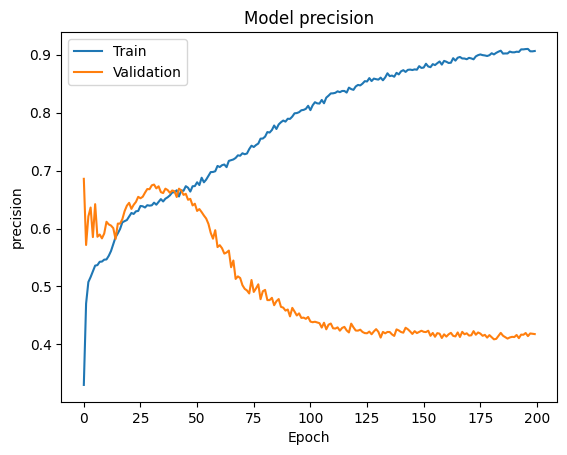

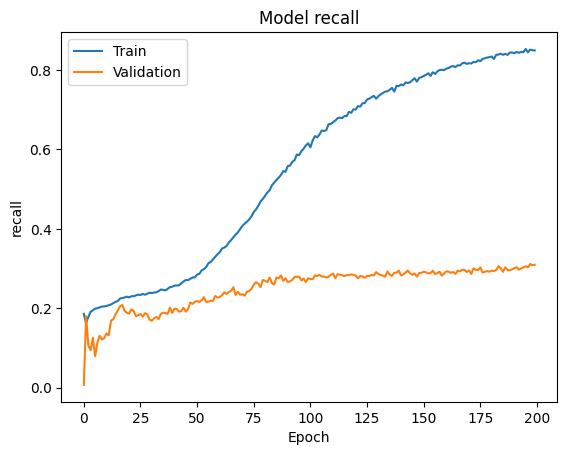

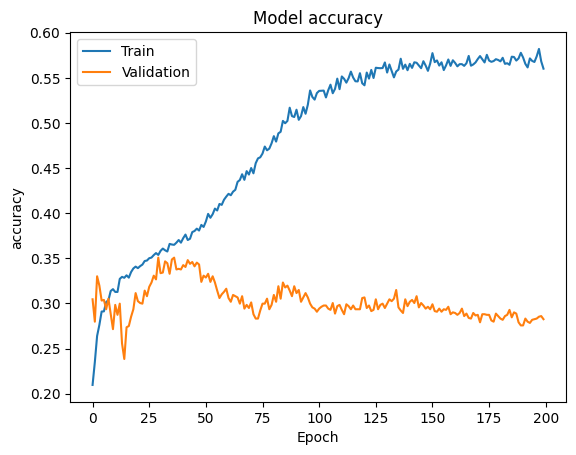

In [18]:
plot_metric(history, 'precision', 'val_precision')
plot_metric(history, 'recall', 'val_recall')
plot_metric(history, 'accuracy', 'val_accuracy')



# **Model Evaluation**

In [19]:
# Load the best weights into the model
checkpoint_dir = '/content/'  # Make sure this directory is correct
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)

if latest_checkpoint:
    model.load_weights(latest_checkpoint)
    print("Model loaded weights from checkpoint: ", latest_checkpoint)
else:
    print("Checkpoint not found.")


Model loaded weights from checkpoint:  /content/checkpoint


In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_and_preprocess_image(image_path):
    # Load the image with the target size you used for training
    img = load_img(image_path, target_size=(64, 64))

    # Convert the image to array
    img_array = img_to_array(img)

    # Normalize the image array if your training data was normalized
    img_array = img_array / 255.0

    # Add a batch dimension (model expects input in batches)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array


1/1 [==============================] - 0s 17ms/step


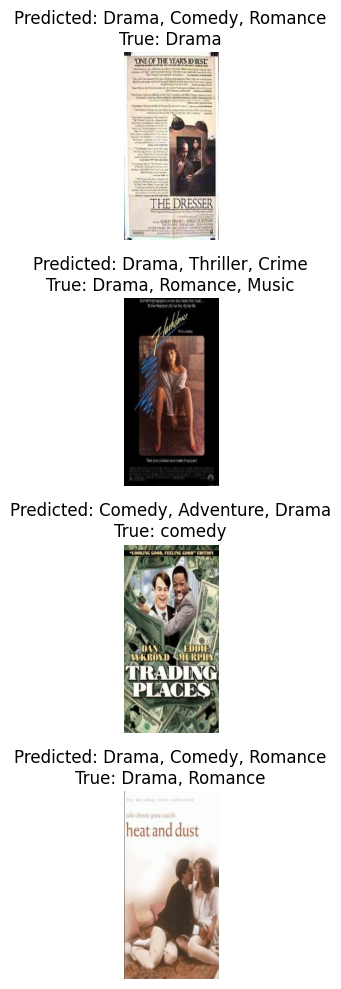

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define the variables again with the correct paths and labels
sample_image_paths = [
    '/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images/tt0085461.jpg',
    '/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images/tt0085549.jpg',
    '/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images/tt0086465.jpg',
    '/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images/tt0084058.jpg'
]

ground_truth_labels = [
    ['Drama'],
    ['Drama','Romance','Music'],
    ['comedy'],
    ['Drama','Romance']
]

# Define the function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(64, 64))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Assuming images were normalized during training
    img_array = np.expand_dims(img_array, axis=0)  # Model expects a batch dimension
    return img_array

# Define the function to predict genres
def predict_genres(model, image_path, genre_list, top_k=3):
    img_array = load_and_preprocess_image(image_path)
    prediction = model.predict(img_array)
    top_indices = prediction[0].argsort()[-top_k:][::-1]
    return [genre_list[idx] for idx in top_indices]

# Define the function to plot predictions
def plot_predictions_vs_truth(image_paths, predicted_genres_list, ground_truth_labels_list):
    num_images = len(image_paths)
    plt.figure(figsize=(12, 10))
    for i in range(num_images):
        img = plt.imread(image_paths[i])
        plt.subplot(num_images, 1, i + 1)
        plt.imshow(img)
        plt.title(f"Predicted: {', '.join(predicted_genres_list[i])}\nTrue: {', '.join(ground_truth_labels_list[i])}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Now let's make predictions and plot them
predicted_genres_list = [predict_genres(model, image_path, genres) for image_path in sample_image_paths]
plot_predictions_vs_truth(sample_image_paths, predicted_genres_list, ground_truth_labels)


# **confusion matrix**

23/23 [==============================] - 2s 80ms/step


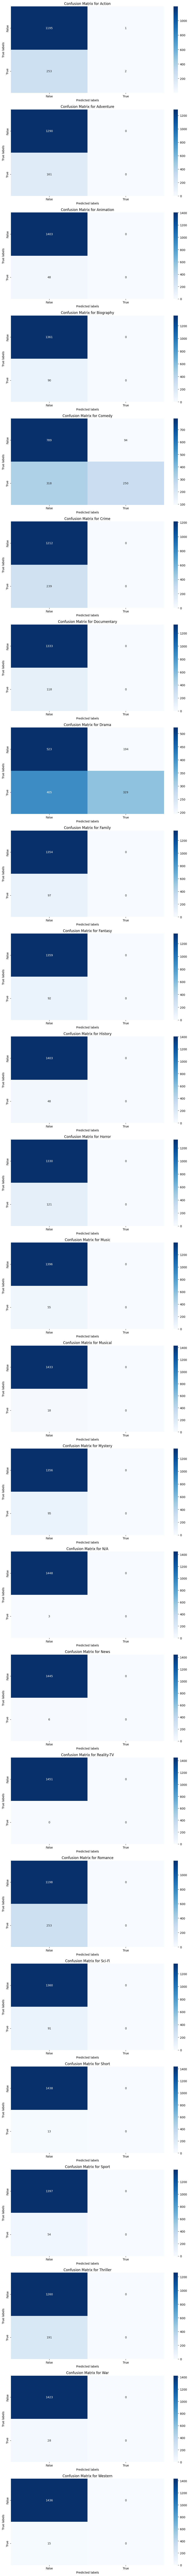

In [22]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sns

def predict_test_dataset(model, dataset):
    predictions = model.predict(dataset)
    # Apply a threshold of 0.5 to convert probabilities to binary labels
    predictions_thresholded = (predictions > 0.5).astype(int)
    return predictions_thresholded

def plot_multilabel_confusion_matrix(y_true, y_pred, labels):
    # Compute confusion matrices for each label
    mcm = multilabel_confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(len(labels), 1, figsize=(10, 5 * len(labels)))
    if len(labels) == 1:
        ax = [ax]
    for i, confusion_matrix in enumerate(mcm):
        sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[i])
        ax[i].set_xlabel('Predicted labels')
        ax[i].set_ylabel('True labels')
        ax[i].set_title(f'Confusion Matrix for {labels[i]}')
        ax[i].xaxis.set_ticklabels(['False', 'True'])
        ax[i].yaxis.set_ticklabels(['False', 'True'])
    plt.tight_layout()
    plt.show()

# Assuming 'val_dataset' is your test dataset and 'genres' are your genre labels
# Extract true labels for the test dataset
true_labels = np.concatenate([y for x, y in val_dataset], axis=0)

# Predict labels for the test dataset
predicted_labels = predict_test_dataset(model, val_dataset)

# Plot confusion matrices for each genre
plot_multilabel_confusion_matrix(true_labels, predicted_labels, genres)


# **Test Image1**

In [35]:
#row 100...labels drama and romance
from PIL import Image
import numpy as np

def prepare_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size, Image.ANTIALIAS)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255  # Normalizing to [0, 1] range if that's what the model expects
    image = np.expand_dims(image, axis=0)  # Model expects a batch dimension
    return image

image_path = '/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images/tt0084058.jpg'
prepared_image = prepare_image(image_path, target_size=(64, 64))  # adjust target_size as per your model's input size

def predict_image(model, image):
    prediction = model.predict(image)
    return prediction

prediction = predict_image(model, prepared_image)
print("Prediction:", prediction)

1/1 [==============================] - 0s 16ms/step
Prediction: [[0.18857719 0.16355869 0.04083134 0.1731752  0.39867693 0.20282735
  0.18405202 0.6341815  0.10711681 0.14882046 0.11333999 0.0856359
  0.10835326 0.06013688 0.11664509 0.01319711 0.02721671 0.00820408
  0.3658286  0.08101282 0.02639984 0.09120778 0.16453828 0.10706345
  0.04146552]]


<ipython-input-35-ed2bbbb388b7>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)


# **Test Image2**

In [24]:
#label comedy row 4
from PIL import Image
import numpy as np

def prepare_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size, Image.ANTIALIAS)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255  # Normalizing to [0, 1] range if that's what the model expects
    image = np.expand_dims(image, axis=0)  # Model expects a batch dimension
    return image

image_path = '/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images/tt0086465.jpg'
prepared_image = prepare_image(image_path, target_size=(64, 64))  # adjust target_size as per your model's input size
def predict_image(model, image):
    prediction = model.predict(image)
    return prediction

prediction = predict_image(model, prepared_image)
print("Prediction:", prediction)



1/1 [==============================] - 0s 16ms/step
Prediction: [[0.3400864  0.28257653 0.14473121 0.08478945 0.5065997  0.24141243
  0.18864617 0.3496508  0.14065881 0.13015762 0.04708363 0.09517304
  0.09852676 0.04823272 0.07951339 0.01047477 0.01310817 0.00404904
  0.1425885  0.12953608 0.0159733  0.08593355 0.16242024 0.0394692
  0.02462648]]


<ipython-input-24-cd84d843d44f>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)


# **Test Image3**

In [29]:
#row 13...label(comedy and drama)
from PIL import Image
import numpy as np

def prepare_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size, Image.ANTIALIAS)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255  # Normalizing to [0, 1] range if that's what the model expects
    image = np.expand_dims(image, axis=0)  # Model expects a batch dimension
    return image

image_path = '/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images/tt0085244.jpg'
prepared_image = prepare_image(image_path, target_size=(64, 64))  # adjust target_size as per your model's input size
def predict_image(model, image):
    prediction = model.predict(image)
    return prediction

prediction = predict_image(model, prepared_image)
print("Prediction:", prediction)

import numpy as np

# Example prediction array
prediction = np.array([[0.06864993, 0.10180947, 0.04592393, 0.1687553, 0.6038836, 0.11854135,
                        0.20817028, 0.6389031, 0.21697105, 0.20085077, 0.14295419, 0.09169953,
                        0.22613627, 0.07555406, 0.11733431, 0.01930527, 0.09016516, 0.00889542,
                        0.46848854, 0.05602261, 0.04805718, 0.14326571, 0.07977712, 0.20600162,
                        0.07589588]])
threshold = float(0.5)
# Apply threshold to convert probabilities to binary values
binary_prediction = np.where(prediction > 0.5, 1, 0)

print("Binary Prediction:", binary_prediction)



1/1 [==============================] - 0s 17ms/step
Prediction: [[0.18005395 0.1488318  0.04193842 0.17992477 0.44289124 0.21300933
  0.22074977 0.58721715 0.11855096 0.1441775  0.11624894 0.10033268
  0.12709351 0.0675825  0.11986412 0.01472493 0.03190765 0.00905205
  0.3354436  0.08533752 0.02964463 0.10128212 0.17497313 0.10802978
  0.04123865]]
Binary Prediction: [[0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


<ipython-input-29-6810c305663c>:6: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)


# **Test Image4**

In [34]:
#row 80...label(drama)
from PIL import Image
import numpy as np

def prepare_image(image_path, target_size):
    image = Image.open(image_path)
    image = image.resize(target_size, Image.ANTIALIAS)
    image = np.array(image)
    image = image.astype('float32')
    image /= 255  # Normalizing to [0, 1] range if that's what the model expects
    image = np.expand_dims(image, axis=0)  # Model expects a batch dimension
    return image

image_path = '/content/drive/MyDrive/Multi_Label_dataset (1)/Multi_Label_dataset/Images/tt0085461.jpg'
prepared_image = prepare_image(image_path, target_size=(64, 64))  # adjust target_size as per your model's input size
def predict_image(model, image):
    prediction = model.predict(image)
    return prediction

prediction = predict_image(model, prepared_image)
print("Prediction:", prediction)



1/1 [==============================] - 0s 19ms/step
Prediction: [[0.17464538 0.14139074 0.03305801 0.19572407 0.40164727 0.22186878
  0.22167775 0.6150503  0.09889    0.1488708  0.13361235 0.11090939
  0.12881643 0.06470149 0.13602939 0.0151301  0.03199069 0.00981265
  0.3220831  0.08930292 0.03367172 0.09055831 0.18960334 0.11743764
  0.04340298]]


<ipython-input-34-e006b1f57986>:7: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  image = image.resize(target_size, Image.ANTIALIAS)
